In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !ls /content/drive/MyDrive/

In [2]:
# Navigate to the folder where the dataset is stored
import os
project_path = '/content/drive/MyDrive'
os.chdir(project_path)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive


In [4]:
import zipfile

# Path to the zip file
zip_file_path = os.path.join(project_path, 'GOPRO_Large.zip')  # Update if your file is in a different location
extract_dir = os.path.join('/content', 'GOPRO_Large')

# Extract the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GOPRO_Large.zip'

In [ ]:
extract_dir = '/content/GOPRO_Large'
# Verify folder structure
for root, dirs, files in os.walk(extract_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {len(files)}")
    break  # Only show the top level for clarity

Root: /content/GOPRO_Large
Directories: ['test', 'train']
Files: 0


In [ ]:
# Example structure (pseudo-code):
# Move 'blurred' images to train/blurred/ and 'sharp' images to train/sharp/
# Similarly, create test/blurred/ and test/sharp/
import shutil

# Organize your dataset as required (this is just an outline)
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images (example)
# shutil.move(src_file_path, os.path.join(train_dir, 'blurred', file_name))

# Loading Libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Loading the dataset

In [ ]:
import glob

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset root directory.
            transform (callable, optional): Transformations to apply to images.
        """
        self.transform = transform

        # Collect all blur and sharp image paths
        self.blurred_paths = sorted(glob.glob(f"{root_dir}/**/blur/*.*", recursive=True))
        self.sharp_paths = sorted(glob.glob(f"{root_dir}/**/sharp/*.*", recursive=True))

        # Sanity check to ensure pairs are matched
        assert len(self.blurred_paths) == len(self.sharp_paths), "Mismatch in blur and sharp image counts."

    def __len__(self):
        return len(self.blurred_paths)

    def __getitem__(self, idx):
        # Load blurred and sharp images
        blurred_image = Image.open(self.blurred_paths[idx]).convert('RGB')
        sharp_image = Image.open(self.sharp_paths[idx]).convert('RGB')

        # Apply transformations
        if self.transform:
            blurred_image = self.transform(blurred_image)
            sharp_image = self.transform(sharp_image)

        return blurred_image, sharp_image

# Preprocessing

In [ ]:
# Define preprocessing transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [ ]:
# Define dataset paths
train_dir = '/content/GOPRO_Large/train'
test_dir = '/content/GOPRO_Large/test'

# Create Dataset instances
train_dataset = GoProDataset(root_dir=train_dir, transform=image_transforms)
test_dataset = GoProDataset(root_dir=test_dir, transform=image_transforms)

# Test the Dataset class
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Example of accessing a sample
blurred_sample, sharp_sample = train_dataset[0]
print(f"Blurred Image Shape: {blurred_sample.shape}")
print(f"Sharp Image Shape: {sharp_sample.shape}")

Number of training samples: 2103
Number of testing samples: 1111
Blurred Image Shape: torch.Size([3, 256, 256])
Sharp Image Shape: torch.Size([3, 256, 256])


# Visiualization

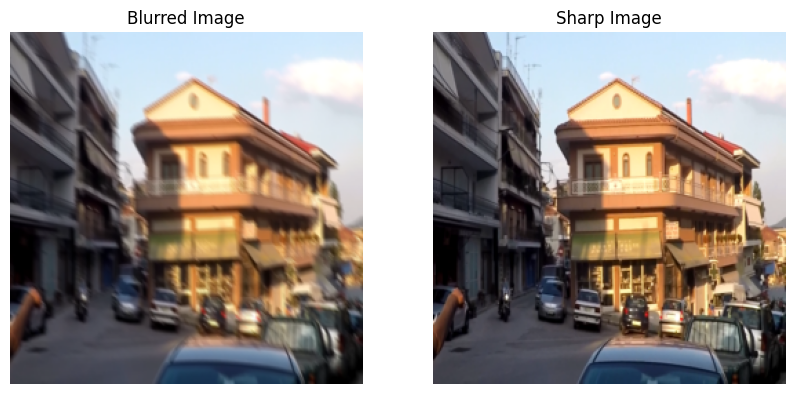

In [ ]:
import matplotlib.pyplot as plt

# Display blurred and sharp image samples
blurred_sample, sharp_sample = train_dataset[0]

# Convert tensors to numpy arrays for visualization
blurred_sample = blurred_sample.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Undo normalization
sharp_sample = sharp_sample.permute(1, 2, 0).numpy() * 0.5 + 0.5       # Undo normalization

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_sample)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Sharp Image")
plt.imshow(sharp_sample)
plt.axis("off")

plt.show()

# Architecture


## Generator

In [ ]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_bn=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.down1 = down_block(3, 64, use_bn=False)  # Input: 3 channels (RGB)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512, use_bn=False)

        self.up1 = up_block(512, 512)
        self.up2 = up_block(1024, 512)  # Skip connections, so input channels double
        self.up3 = up_block(1024, 256)
        self.up4 = up_block(512, 128)
        self.up5 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Upsampling
        u1 = self.up1(d6)
        u2 = self.up2(torch.cat([u1, d5], dim=1))
        u3 = self.up3(torch.cat([u2, d4], dim=1))
        u4 = self.up4(torch.cat([u3, d3], dim=1))
        u5 = self.up5(torch.cat([u4, d2], dim=1))

        # Final layer
        out = self.final(torch.cat([u5, d1], dim=1))
        return out

## Discriminator

In [ ]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(6, 64, use_bn=False),  # Input: 6 channels (blurred + sharp)
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Final output
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Test the generator
generator = UNetGenerator()
blurred_sample = torch.randn(1, 3, 256, 256)  # Example input
deblurred_sample = generator(blurred_sample)
print(f"Deblurred Image Shape: {deblurred_sample.shape}")

# Test the discriminator
discriminator = PatchGANDiscriminator()
input_pair = torch.cat([blurred_sample, deblurred_sample], dim=1)
discriminator_output = discriminator(input_pair)
print(f"Discriminator Output Shape: {discriminator_output.shape}")

Deblurred Image Shape: torch.Size([1, 3, 256, 256])
Discriminator Output Shape: torch.Size([1, 1, 15, 15])


In [ ]:
# Adversarial Loss: Binary Cross-Entropy
adversarial_loss = nn.BCEWithLogitsLoss()

In [ ]:
from torchvision.models import vgg19
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.vgg_layers = nn.Sequential(*list(vgg[:12]))  # Use the first few layers of VGG
        for param in self.vgg_layers.parameters():
            param.requires_grad = False  # Freeze the VGG layers

        # Move the VGG model to GPU
        self.vgg_layers = self.vgg_layers.to('cuda')

    def forward(self, generated, target):
        # Normalize input to VGG model's expected range [0, 1]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to('cuda')
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to('cuda')
        generated = (generated + 1) / 2.0  # Convert from [-1, 1] to [0, 1]
        target = (target + 1) / 2.0

        generated = (generated - mean) / std
        target = (target - mean) / std

        # Extract feature maps
        generated_features = self.vgg_layers(generated)
        target_features = self.vgg_layers(target)

        # Compute L1 loss on feature maps
        loss = nn.functional.l1_loss(generated_features, target_features)
        return loss

In [ ]:
# L1 Reconstruction Loss
reconstruction_loss = nn.L1Loss()

In [ ]:
# Initialize Perceptual Loss
perceptual_loss_fn = PerceptualLoss()

# Ensure the generator is on the GPU
generator = generator.to('cuda')

# Move input tensor to GPU
blurred_sample = blurred_sample.to('cuda')

# Generate the deblurred image
generated_images = generator(blurred_sample)
sharp_images = torch.randn(1, 3, 256, 256).to('cuda')   # Example ground truth sharp images

# Compute Perceptual Loss
perc_loss = perceptual_loss_fn(generated_images, sharp_images)
print(f"Perceptual Loss: {perc_loss.item()}")

# # Compute Adversarial Loss for real and fake
# real_labels = torch.ones((1, 1, 15, 15))  # Labels for real images
# fake_labels = torch.zeros((1, 1, 15, 15))  # Labels for fake images

# real_loss = adversarial_loss(discriminator(torch.cat([sharp_images, sharp_images], dim=1)), real_labels)
# fake_loss = adversarial_loss(discriminator(torch.cat([blurred_sample, generated_images], dim=1)), fake_labels)
# adv_loss = (real_loss + fake_loss) / 2

# print(f"Adversarial Loss: {adv_loss.item()}")

# Compute Adversarial Loss for real and fake
real_labels = torch.ones((1, 1, 15, 15)).to('cuda')  # Labels for real images
fake_labels = torch.zeros((1, 1, 15, 15)).to('cuda')  # Labels for fake images

discriminator = discriminator.to('cuda')

# Compute losses
real_loss = adversarial_loss(discriminator(torch.cat([sharp_images, sharp_images], dim=1)), real_labels)
fake_loss = adversarial_loss(discriminator(torch.cat([blurred_sample, generated_images], dim=1)), fake_labels)
adv_loss = (real_loss + fake_loss) / 2

print(f"Adversarial Loss: {adv_loss.item()}")


# Compute Reconstruction Loss
recon_loss = reconstruction_loss(generated_images, sharp_images)
print(f"Reconstruction Loss: {recon_loss.item()}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Perceptual Loss: 4.504585266113281
Adversarial Loss: 0.7185314297676086
Reconstruction Loss: 0.9590255618095398


# Training Code

In [ ]:
from torch.utils.data import DataLoader

# Define DataLoader parameters
batch_size = 8
num_workers = 2

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
# import torch.optim as optim

# # Initialize models
# generator = UNetGenerator().to('cuda')
# discriminator = PatchGANDiscriminator().to('cuda')

# # Optimizers
# lr = 2e-4
# betas = (0.5, 0.999)

# optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=betas)
# optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# # Loss weights
# lambda_adv = 1.0
# lambda_perc = 10.0
# lambda_recon = 100.0

# # Training loop
# num_epochs = 100
# for epoch in range(num_epochs):
#     generator.train()
#     discriminator.train()

#     for i, (blurred_images, sharp_images) in enumerate(train_loader):
#         # Move data to GPU
#         blurred_images = blurred_images.to('cuda')
#         sharp_images = sharp_images.to('cuda')

#         # ---------------------------------
#         # Train Discriminator
#         # ---------------------------------
#         optimizer_d.zero_grad()

#         # Real pairs (blurred + sharp)
#         real_inputs = torch.cat([blurred_images, sharp_images], dim=1)
#         real_labels = torch.ones((real_inputs.size(0), 1, 15, 15)).to('cuda')

#         # Fake pairs (blurred + generated)
#         generated_images = generator(blurred_images)
#         fake_inputs = torch.cat([blurred_images, generated_images], dim=1)
#         fake_labels = torch.zeros((fake_inputs.size(0), 1, 15, 15)).to('cuda')

#         # Compute adversarial loss for real and fake
#         real_loss = adversarial_loss(discriminator(real_inputs), real_labels)
#         fake_loss = adversarial_loss(discriminator(fake_inputs.detach()), fake_labels)
#         d_loss = (real_loss + fake_loss) / 2

#         d_loss.backward()
#         optimizer_d.step()

#         # ---------------------------------
#         # Train Generator
#         # ---------------------------------
#         optimizer_g.zero_grad()

#         # Adversarial loss (fooling the discriminator)
#         adv_loss = adversarial_loss(discriminator(fake_inputs), real_labels)

#         # Perceptual loss
#         perc_loss = perceptual_loss_fn(generated_images, sharp_images)

#         # Reconstruction loss
#         recon_loss = reconstruction_loss(generated_images, sharp_images)

#         # Total generator loss
#         g_loss = lambda_adv * adv_loss + lambda_perc * perc_loss + lambda_recon * recon_loss

#         g_loss.backward()
#         optimizer_g.step()

#         # Logging (print progress every few steps)
#         if i % 100 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}]")
#             print(f"  Discriminator Loss: {d_loss.item():.4f}")
#             print(f"  Generator Loss: {g_loss.item():.4f} (Adv: {adv_loss.item():.4f}, Perc: {perc_loss.item():.4f}, Recon: {recon_loss.item():.4f})")

#     # Save model checkpoints
#     torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
#     torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}.pth')

Epoch [1/100], Step [0/263]
  Discriminator Loss: 0.7112
  Generator Loss: 92.3463 (Adv: 1.0667, Perc: 2.9515, Recon: 0.6176)
Epoch [1/100], Step [100/263]
  Discriminator Loss: 0.4158
  Generator Loss: 21.4754 (Adv: 0.7638, Perc: 1.1746, Recon: 0.0897)
Epoch [1/100], Step [200/263]
  Discriminator Loss: 0.4307
  Generator Loss: 20.0696 (Adv: 1.7918, Perc: 1.0209, Recon: 0.0807)
Epoch [2/100], Step [0/263]
  Discriminator Loss: 0.1290
  Generator Loss: 20.5053 (Adv: 2.3184, Perc: 1.0248, Recon: 0.0794)
Epoch [2/100], Step [100/263]
  Discriminator Loss: 0.8766
  Generator Loss: 15.8606 (Adv: 0.9345, Perc: 0.8519, Recon: 0.0641)
Epoch [2/100], Step [200/263]
  Discriminator Loss: 0.2483
  Generator Loss: 17.9703 (Adv: 2.7240, Perc: 0.8454, Recon: 0.0679)
Epoch [3/100], Step [0/263]
  Discriminator Loss: 0.0484
  Generator Loss: 20.7438 (Adv: 3.7135, Perc: 0.9241, Recon: 0.0779)
Epoch [3/100], Step [100/263]
  Discriminator Loss: 0.1139
  Generator Loss: 19.3374 (Adv: 2.7937, Perc: 0.923

In [ ]:
import os

# Define a path in your Google Drive to save the models
save_dir = "/content/drive/MyDrive/GAN_Deblurring_Models"
os.makedirs(save_dir, exist_ok=True)

# Save the generator and discriminator models
torch.save(generator.state_dict(), os.path.join(save_dir, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(save_dir, "discriminator.pth"))

print(f"Models saved to {save_dir}")

Models saved to /content/drive/MyDrive/GAN_Deblurring_Models


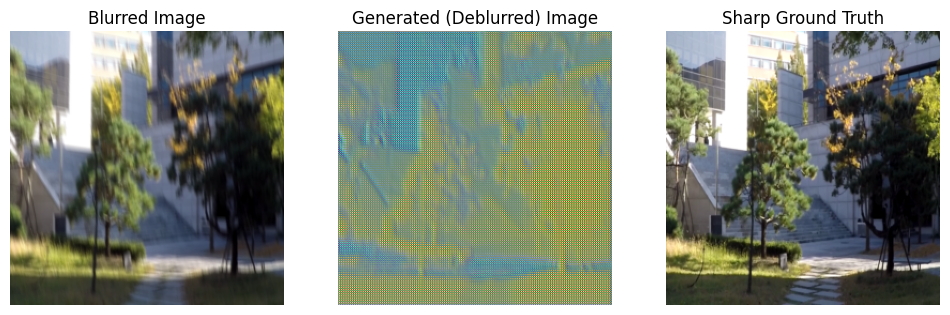

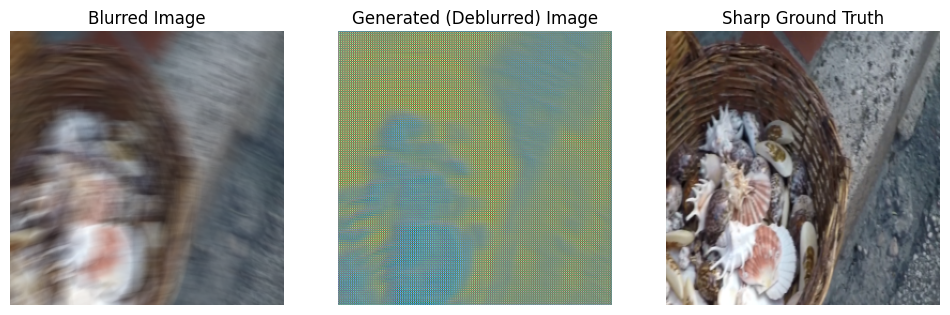

In [ ]:
import matplotlib.pyplot as plt

# Function to denormalize images for visualization
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Convert from [-1, 1] to [0, 1]
    return tensor.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) format

# Visualize a batch of results
generator.eval()  # Set generator to evaluation mode
with torch.no_grad():
    blurred_batch, sharp_batch = next(iter(train_loader))
    blurred_batch = blurred_batch.to('cuda')
    generated_batch = generator(blurred_batch)

    # Visualize the first image in the batch
    for i in range(2):  # Visualize 2 examples
        plt.figure(figsize=(12, 4))

        # Blurred Image
        plt.subplot(1, 3, 1)
        plt.title("Blurred Image")
        plt.imshow(denormalize(blurred_batch[i]))
        plt.axis("off")

        # Generated Image
        plt.subplot(1, 3, 2)
        plt.title("Generated (Deblurred) Image")
        plt.imshow(denormalize(generated_batch[i]))
        plt.axis("off")

        # Sharp Ground Truth
        plt.subplot(1, 3, 3)
        plt.title("Sharp Ground Truth")
        plt.imshow(denormalize(sharp_batch[i]))
        plt.axis("off")

        plt.show()

# Testing the code

In [ ]:
# Define the directory where models are saved
save_dir = "/content/drive/MyDrive/GAN_Deblurring_Models"

dir = "/content/drive/MyDrive/generator_epoch_100.pth"
# Initialize the generator
generator = UNetGenerator().to('cuda')

# Load the saved generator weights
# generator.load_state_dict(torch.load(os.path.join(save_dir, "generator.pth")))
generator.load_state_dict(torch.load(dir))

generator.eval()  # Set to evaluation mode

UNetGenerator(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding

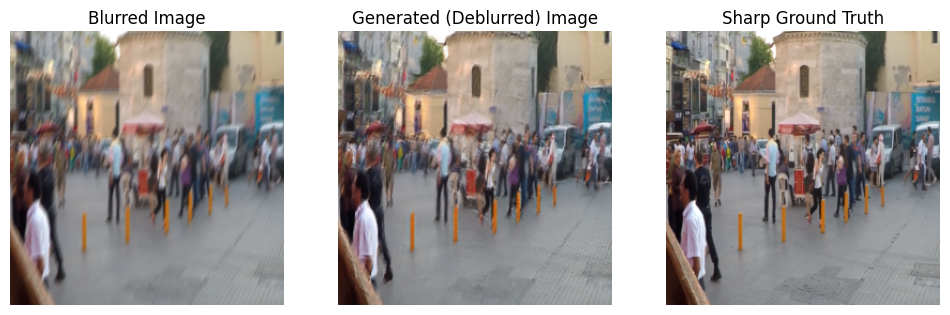

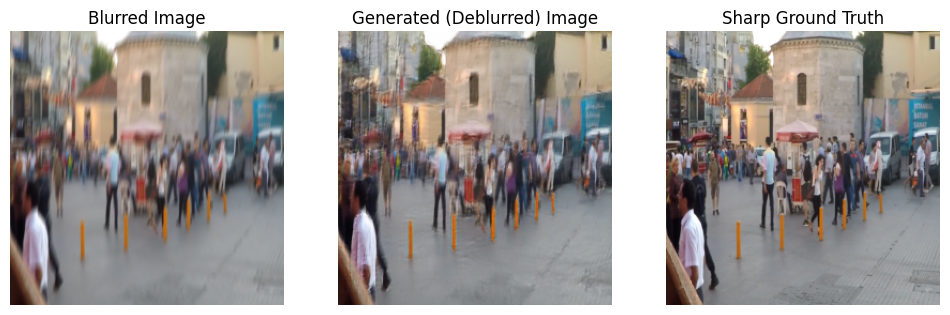

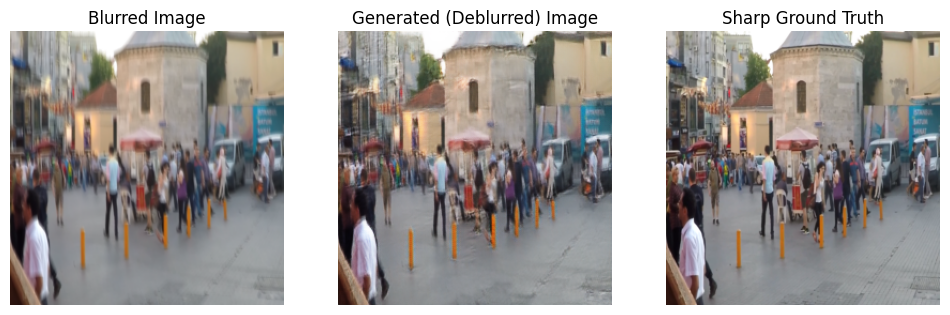

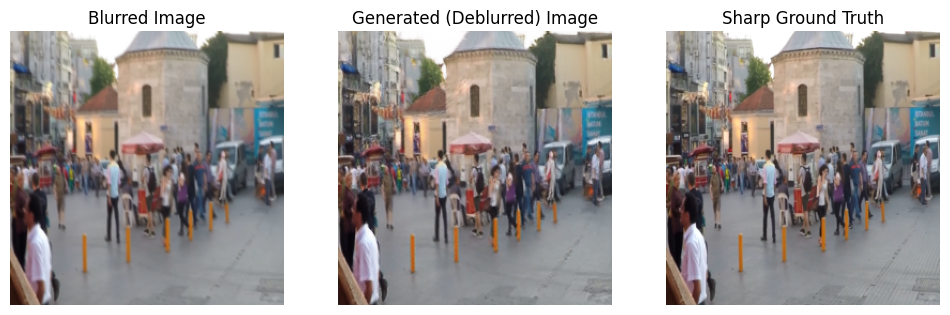

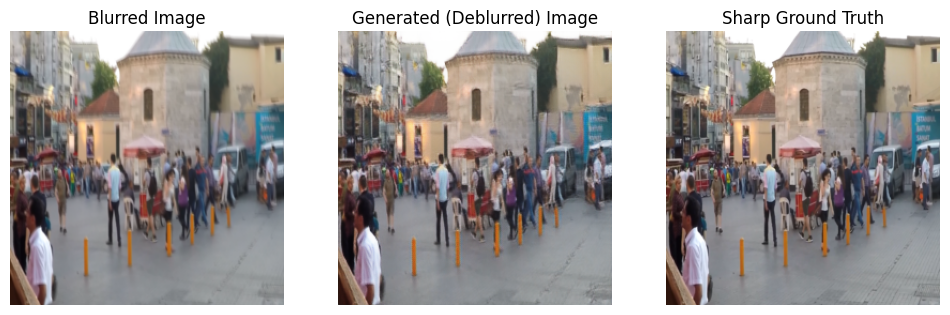

In [ ]:
import matplotlib.pyplot as plt
import torch

def denormalize(tensor):
    """
    Undo normalization and convert tensor to numpy array for visualization.
    Args:
        tensor (torch.Tensor): A normalized tensor with shape (C, H, W).
    Returns:
        numpy.ndarray: A denormalized image in numpy format (H, W, C).
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)

    # Reverse normalization
    tensor = tensor * std.view(-1, 1, 1) + mean.view(-1, 1, 1)  # Denormalize per channel

    # Convert to numpy and permute dimensions
    return tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format


# Load the test dataset
test_dir = "/content/GOPRO_Large/test"
test_dataset = GoProDataset(root_dir=test_dir, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

import matplotlib.pyplot as plt

# Visualize results for a few test images
for i, (blurred_image, sharp_image) in enumerate(test_loader):
    if i == 5:  # Display results for 5 test images
        break

    blurred_image = blurred_image.to('cuda')

    # Generate deblurred image
    with torch.no_grad():
        deblurred_image = generator(blurred_image)

    # Select the first image in the batch
    blurred_image = blurred_image[0]
    deblurred_image = deblurred_image[0]
    sharp_image = sharp_image[0]

    # Denormalize for visualization
    blurred_image = denormalize(blurred_image)
    deblurred_image = denormalize(deblurred_image)
    sharp_image = denormalize(sharp_image)

    # Plot the results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Blurred Image")
    plt.imshow(blurred_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Generated (Deblurred) Image")
    plt.imshow(deblurred_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Sharp Ground Truth")
    plt.imshow(sharp_image)
    plt.axis("off")

    plt.show()

In [ ]:
import torch
import math
from skimage.metrics import structural_similarity as compare_ssim

# Mean Squared Error (MSE)
def mse_loss(image1, image2):
    return torch.mean((image1 - image2) ** 2).item()

# Peak Signal-to-Noise Ratio (PSNR)
def psnr(image1, image2):
    mse = mse_loss(image1, image2)
    if mse == 0:
        return float("inf")  # Avoid division by zero
    return 20 * math.log10(1.0 / math.sqrt(mse))

# Structural Similarity Index (SSIM)
def ssim(image1, image2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    Args:
        image1 (torch.Tensor): Generated image (C, H, W).
        image2 (torch.Tensor): Ground truth image (C, H, W).
    Returns:
        float: SSIM value.
    """
    # Convert tensors to numpy arrays
    image1 = image1.permute(1, 2, 0).cpu().numpy()  # HWC format
    image2 = image2.permute(1, 2, 0).cpu().numpy()  # HWC format

    # Dynamically set win_size based on image dimensions
    min_dim = min(image1.shape[0], image1.shape[1])  # Smallest dimension
    win_size = min(7, min_dim)  # Ensure win_size <= 7 and <= smallest dimension

    if win_size % 2 == 0:
        win_size -= 1  # Ensure win_size is odd

    # print(f"Using win_size={win_size} for SSIM calculation.")  # Debug info

    return compare_ssim(image1, image2, channel_axis=-1, data_range=1.0, win_size=win_size)

In [ ]:
import torch.nn.functional as F

# Helper Functions
def custom_preprocess(image):
    """
    Preprocess the image while keeping its original size.
    Args:
        image (PIL.Image): Input image to preprocess.
    Returns:
        torch.Tensor: Preprocessed image as a PyTorch tensor.
    """
    preprocess = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor (preserves original size)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])
    return preprocess(image)

def denormalize(tensor):
    """
    Undo normalization and convert tensor to numpy array for visualization.
    Args:
        tensor (torch.Tensor): A normalized tensor with shape (C, H, W).
    Returns:
        numpy.ndarray: A denormalized image in numpy format (H, W, C).
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)
    tensor = tensor * std.view(-1, 1, 1) + mean.view(-1, 1, 1)  # Reverse normalization
    return tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

def pad_image(image_tensor, divisor=32):
    """
    Pads the input image tensor so that its height and width are divisible by 'divisor'.
    Args:
        image_tensor (torch.Tensor): Input image tensor of shape (1, C, H, W).
        divisor (int): The factor by which H and W should be divisible.
    Returns:
        padded_tensor (torch.Tensor): Padded image tensor.
        padding (tuple): Padding applied (left, right, top, bottom).
    """
    _, _, h, w = image_tensor.shape
    pad_h = (divisor - h % divisor) % divisor
    pad_w = (divisor - w % divisor) % divisor

    padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)  # (left, right, top, bottom)
    padded_tensor = F.pad(image_tensor, padding, mode='reflect')
    return padded_tensor, padding

def remove_padding(image_tensor, padding):
    """
    Removes padding from the image tensor.
    Args:
        image_tensor (torch.Tensor): Padded image tensor of shape (C, H, W).
        padding (tuple): Padding applied (left, right, top, bottom).
    Returns:
        cropped_tensor (torch.Tensor): Image tensor with padding removed.
    """
    left, right, top, bottom = padding
    return image_tensor[..., top:-bottom or None, left:-right or None]

In [ ]:
# print(f"Generated Image Shape: {gen_image.shape}")
# print(f"Ground Truth Image Shape: {gt_image.shape}")

In [ ]:
# Initialize accumulators for metrics
total_mse, total_psnr, total_ssim = 0.0, 0.0, 0.0
num_images = 0

generator.eval()  # Set the generator to evaluation mode

with torch.no_grad():
    for blurred_image, sharp_image in test_loader:
        blurred_image = blurred_image.to('cuda')
        sharp_image = sharp_image.to('cuda')

        # Generate the deblurred image
        padded_blurred_image, padding = pad_image(blurred_image)
        padded_deblurred_image = generator(padded_blurred_image)
        deblurred_image = remove_padding(padded_deblurred_image, padding)

        # Compute metrics
        for i in range(blurred_image.size(0)):  # Iterate over batch
            gt_image = sharp_image[i]  # Ground truth
            gen_image = deblurred_image[i]  # Generated image

            # Metrics
            mse = mse_loss(gen_image, gt_image)
            psnr_value = psnr(gen_image, gt_image)
            ssim_value = ssim(gen_image, gt_image)

            total_mse += mse
            total_psnr += psnr_value
            total_ssim += ssim_value
            num_images += 1

# Compute average metrics
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Test Set Evaluation Metrics:")
print(f"  Average MSE: {avg_mse:.4f}")
print(f"  Average PSNR: {avg_psnr:.2f} dB")
print(f"  Average SSIM: {avg_ssim:.4f}")

Test Set Evaluation Metrics:
  Average MSE: 0.0082
  Average PSNR: 22.33 dB
  Average SSIM: 0.8134


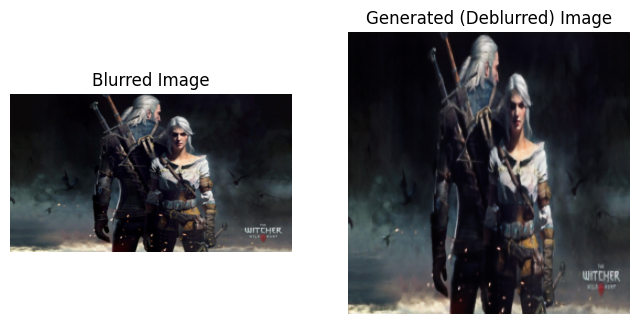

In [ ]:
from PIL import Image
import torchvision.transforms as transforms


# Load and preprocess an external blurred image
image_path = "/content/blurred_image.jpg"
blurred_image = Image.open(image_path).convert("RGB")

# Apply the same transformations as during training
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
blurred_image_tensor = preprocess(blurred_image).unsqueeze(0).to('cuda')  # Add batch dimension

# Generate deblurred image
with torch.no_grad():
    deblurred_image_tensor = generator(blurred_image_tensor)

# Denormalize for visualization
deblurred_image = denormalize(deblurred_image_tensor[0])

# Display the original and deblurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated (Deblurred) Image")
plt.imshow(deblurred_image)
plt.axis("off")

plt.show()

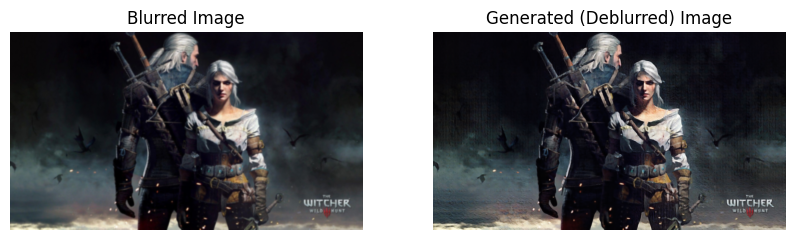

In [ ]:
# Preprocess the custom blurred image
blurred_image_tensor = custom_preprocess(blurred_image).unsqueeze(0).to('cuda')  # Add batch dimension

# Pad the image to make its dimensions divisible by 32
padded_blurred_image, padding = pad_image(blurred_image_tensor)

# Generate deblurred image
with torch.no_grad():
    padded_deblurred_image = generator(padded_blurred_image)

# Remove padding from the generated image
deblurred_image_tensor = remove_padding(padded_deblurred_image, padding)

# Denormalize for visualization
blurred_image = denormalize(blurred_image_tensor[0])
deblurred_image = denormalize(deblurred_image_tensor[0])

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated (Deblurred) Image")
plt.imshow(deblurred_image)
plt.axis("off")

plt.show()

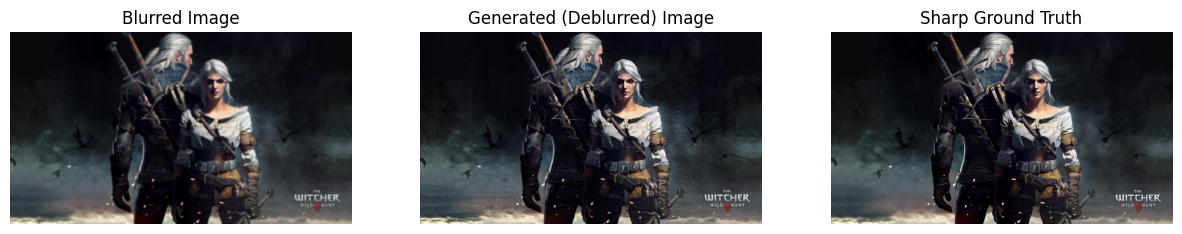

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Load the custom blurred image and sharp image
blurred_image_path = "/content/blurred_image.jpg"  # Blurred image path
sharp_image_path = "/content/image.jpg"  # Ground truth image path

blurred_image = Image.open(blurred_image_path).convert("RGB")
sharp_image = Image.open(sharp_image_path).convert("RGB")

# Preprocess the blurred image
blurred_image_tensor = custom_preprocess(blurred_image).unsqueeze(0).to('cuda')  # Add batch dimension

# Pad the blurred image to make its dimensions divisible by 32
padded_blurred_image, padding = pad_image(blurred_image_tensor)

# Generate deblurred image
with torch.no_grad():
    padded_deblurred_image = generator(padded_blurred_image)

# Remove padding from the generated image
deblurred_image_tensor = remove_padding(padded_deblurred_image, padding)

# Denormalize images for visualization
blurred_image_vis = denormalize(blurred_image_tensor[0])
deblurred_image_vis = denormalize(deblurred_image_tensor[0])
sharp_image_vis = denormalize(custom_preprocess(sharp_image).to('cuda'))

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Blurred Image")
plt.imshow(blurred_image_vis)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Generated (Deblurred) Image")
plt.imshow(deblurred_image_vis)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Sharp Ground Truth")
plt.imshow(sharp_image_vis)
plt.axis("off")

plt.show()

In [ ]:
# Ensure the generated and ground truth images have the same dimensions
gen_image = deblurred_image_tensor
gt_image = custom_preprocess(sharp_image).unsqueeze(0).to('cuda')

# MSE
mse_loss = torch.nn.MSELoss()
mse = mse_loss(gen_image, gt_image).item()

# PSNR
def psnr(gen, gt, max_pixel=1.0):
    mse = torch.mean((gen - gt) ** 2)
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

psnr_value = psnr(gen_image, gt_image)

# SSIM
from skimage.metrics import structural_similarity as ssim
import numpy as np

gen_image_np = gen_image.squeeze().permute(1, 2, 0).cpu().numpy()
gt_image_np = gt_image.squeeze().permute(1, 2, 0).cpu().numpy()

ssim_value = ssim(gen_image_np, gt_image_np, data_range=gen_image_np.max() - gen_image_np.min(), channel_axis=-1)

# Display the metrics
print(f"Single Image Evaluation Metrics:")
print(f"  MSE: {mse:.4f}")
print(f"  PSNR: {psnr_value:.2f} dB")
print(f"  SSIM: {ssim_value:.4f}")

Single Image Evaluation Metrics:
  MSE: 0.0141
  PSNR: 18.50 dB
  SSIM: 0.7117


In [ ]:
!pip uninstall -y torch torchvision basicsr realesrgan


Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2
Found existing installation: realesrgan 0.3.0
Uninstalling realesrgan-0.3.0:
  Successfully uninstalled realesrgan-0.3.0


In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install basicsr realesrgan opencv-python numpy


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 737.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.5 MB/s eta 0:00:00
IN

  Using cached basicsr-1.4.2-py3-none-any.whl
  Using cached realesrgan-0.3.0-py3-none-any.whl.metadata (17 kB)
Using cached realesrgan-0.3.0-py3-none-any.whl (26 kB)


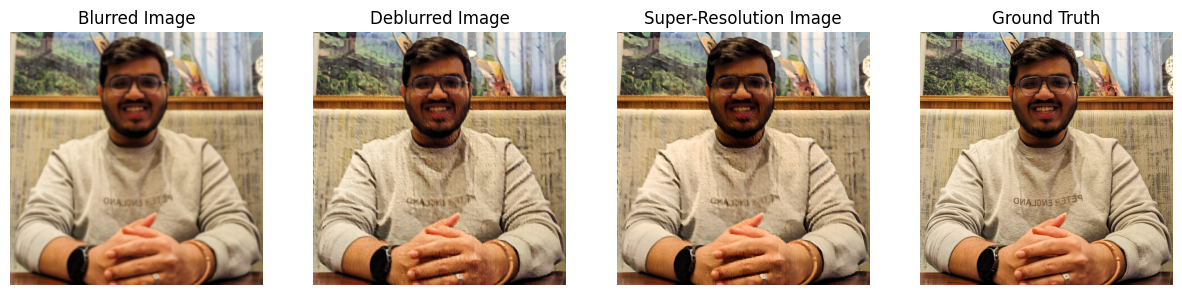

Enhanced image saved at: /content/super_resolved_image.png


In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from basicsr.archs.rrdbnet_arch import RRDBNet  # ESRGAN model architecture
from realesrgan import RealESRGANer  # Pre-trained Super-Resolution model
# from deblurgan_model import UNetGenerator  # Import your DeblurGAN model

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 1️⃣ Clear GPU Cache Before Running ESRGAN (Fix OOM)
torch.cuda.empty_cache()

# ✅ 2️⃣ Load DeblurGAN Model
generator = UNetGenerator().to(device)
deblurgan_model_path = "/content/drive/MyDrive/generator_epoch_100.pth"
generator.load_state_dict(torch.load(deblurgan_model_path, map_location=device))
generator.eval()  # Set to inference mode

# ✅ 3️⃣ Load Super-Resolution Model (ESRGAN)
sr_model_path = '/content/RealESRGAN_x4plus.pth'  # Ensure this file is downloaded
sr_model = RealESRGANer(
    scale=4,  # 4x upscaling
    model_path=sr_model_path,
    model=RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23),
    device=device
)

# # ✅ 4️⃣ Run ESRGAN in Half-Precision (FP16) to Reduce Memory
# sr_model.model.half()

# Helper Functions
def custom_preprocess(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor (preserves original size)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])
    return preprocess(image)

def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device)
    tensor = tensor * std.view(-1, 1, 1) + mean.view(-1, 1, 1)  # Reverse normalization
    return tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

# def pad_image(image_tensor, divisor=32):
#     _, _, h, w = image_tensor.shape
#     pad_h = (divisor - h % divisor) % divisor
#     pad_w = (divisor - w % divisor) % divisor
#     padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
#     padded_tensor = F.pad(image_tensor, padding, mode='reflect')
#     return padded_tensor, padding

# def remove_padding(image_tensor, padding):
#     left, right, top, bottom = padding
#     return image_tensor[..., top:-bottom or None, left:-right or None]



# # ✅ 5️⃣ Function to Apply DeblurGAN
# def deblur_image(image):
#     blurred_image_tensor = custom_preprocess(image).unsqueeze(0).to(device)  # Add batch dimension
#     padded_blurred_image, padding = pad_image(blurred_image_tensor)

#     with torch.no_grad():
#         padded_deblurred_image = generator(padded_blurred_image)

#     deblurred_image_tensor = remove_padding(padded_deblurred_image, padding)
#     return deblurred_image_tensor


def resize_to_multiple_of_32(image):
    """
    Resizes the image so its dimensions are multiples of 32 before passing to DeblurGAN.
    """
    w, h = image.size
    new_w = (w // 32) * 32
    new_h = (h // 32) * 32
    return image.resize((new_w, new_h), Image.BICUBIC)  # ✅ Use bicubic resizing for smoothness

def deblur_image(image):
    """
    Applies DeblurGAN after resizing & padding the input image to be a multiple of 32.
    """
    # ✅ Resize the input image before converting to tensor
    image = resize_to_multiple_of_32(image)

    # Convert to tensor and normalize
    image_tensor = custom_preprocess(image).unsqueeze(0).to(device)

    # ✅ Pad Image Before Passing to DeblurGAN (If Needed)
    padded_image, padding = pad_image(image_tensor)

    # Apply DeblurGAN
    with torch.no_grad():
        padded_deblurred = generator(padded_image)

    # ✅ Remove Padding After Deblurring
    deblurred_image = remove_padding(padded_deblurred, padding)

    return deblurred_image


def remove_padding(image_tensor, padding):
    """
    Removes padding from the image tensor.
    """
    _, right, _, bottom = padding
    return image_tensor[..., :image_tensor.shape[2] - bottom, :image_tensor.shape[3] - right]








# ✅ 7️⃣ Load the Input Images
blurred_image_path = "/content/blurred_image1.jpg"
sharp_image_path = "/content/image1.jpg"

blurred_image = Image.open(blurred_image_path).convert("RGB")
sharp_image = Image.open(sharp_image_path).convert("RGB")  # Ground truth

# Step 1: Apply DeblurGAN
deblurred_image_tensor = deblur_image(blurred_image)

# Step 2: Convert the deblurred image to a numpy array
deblurred_image_np = (denormalize(deblurred_image_tensor[0]) * 255).astype(np.uint8)

# Step 3: Apply Super-Resolution
sr_image = upscale_image(deblurred_image_np)

# ✅ 8️⃣ Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Blurred Image")
plt.imshow(blurred_image)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Deblurred Image")
plt.imshow(deblurred_image_np)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Super-Resolution Image")
plt.imshow(sr_image)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Ground Truth")
plt.imshow(sharp_image)
plt.axis("off")

plt.show()

# ✅ 9️⃣ Save the Final Enhanced Image
sr_image_path = "/content/super_resolved_image.png"
cv2.imwrite(sr_image_path, cv2.cvtColor(sr_image, cv2.COLOR_RGB2BGR))
print(f"Enhanced image saved at: {sr_image_path}")

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms as transforms

# ✅ Resize Function to Match Ground Truth
def resize_to_match(img_tensor, target_tensor):
    _, _, target_h, target_w = target_tensor.shape
    return F.interpolate(img_tensor, size=(target_h, target_w), mode='bilinear', align_corners=False)

# ✅ Resize the Generated Images to Match Ground Truth
gen_deblur_image = resize_to_match(deblurred_image_tensor, gt_image)
gen_sr_image = resize_to_match(gen_sr_image, gt_image)

# ✅ Define MSE Loss
mse_loss = torch.nn.MSELoss()

# Compute MSE (After Resizing)
mse_deblur = mse_loss(gen_deblur_image, gt_image).item()
mse_sr = mse_loss(gen_sr_image, gt_image).item()

# ✅ Define PSNR Function
def psnr(gen, gt, max_pixel=1.0):
    mse = torch.mean((gen - gt) ** 2)
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

# Compute PSNR
psnr_deblur = psnr(gen_deblur_image, gt_image)
psnr_sr = psnr(gen_sr_image, gt_image)

# ✅ Convert Tensors to NumPy for SSIM Calculation
to_numpy = lambda x: x.squeeze().permute(1, 2, 0).cpu().numpy()
gen_deblur_np = to_numpy(gen_deblur_image)
gen_sr_np = to_numpy(gen_sr_image)
gt_image_np = to_numpy(gt_image)

# Compute SSIM
ssim_deblur = ssim(gen_deblur_np, gt_image_np, data_range=gen_deblur_np.max() - gen_deblur_np.min(), channel_axis=-1)
ssim_sr = ssim(gen_sr_np, gt_image_np, data_range=gen_sr_np.max() - gen_sr_np.min(), channel_axis=-1)

# ✅ Display Results
print(f"📌 Image Quality Evaluation Metrics:")
print(f"-----------------------------------")
print(f"🔹 **Deblurred Image vs Ground Truth**")
print(f"   - MSE: {mse_deblur:.4f}")
print(f"   - PSNR: {psnr_deblur:.2f} dB")
print(f"   - SSIM: {ssim_deblur:.4f}")

print(f"\n🔹 **Super-Resolved Image vs Ground Truth**")
print(f"   - MSE: {mse_sr:.4f}")
print(f"   - PSNR: {psnr_sr:.2f} dB")
print(f"   - SSIM: {ssim_sr:.4f}")

📌 Image Quality Evaluation Metrics:
-----------------------------------
🔹 **Deblurred Image vs Ground Truth**
   - MSE: 0.9505
   - PSNR: 0.22 dB
   - SSIM: -0.1121

🔹 **Super-Resolved Image vs Ground Truth**
   - MSE: 0.0148
   - PSNR: 18.30 dB
   - SSIM: 0.7207
